# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [16]:
import sys
from pathlib import Path
import os
os.environ["HSFS_FQSERVER_DISABLE"] = "1"
def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
if os.path.exists(f"{root_dir}/.env"):
    settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: D:\KTH Courses\ID2223 Scalable Machine Learning and Deep Learning\Lab1\mlfs-book-main\mlfs-book-main
HopsworksSettings initialized!


In [17]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util

In [18]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 16, 0, 56, 38, 751631)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [19]:
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

2025-11-16 00:56:40,323 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-16 00:56:40,331 INFO: Initializing external client
2025-11-16 00:56:40,331 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-16 00:56:41,620 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1303700


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [20]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=1,
)

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

2025-11-16 00:56:49,480 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/541400 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/95103 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/16993 elapsed<00:00 remaining<?

In [21]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='5.5554577E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float'], gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [22]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.70s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2025-11-21 00:00:00+00:00,5.30,0.0,9.028754,4.573841,Paris
1,2025-11-17 00:00:00+00:00,9.15,0.0,17.313717,3.576264,Paris
2,2025-11-19 00:00:00+00:00,8.10,0.0,21.734581,243.435013,Paris
3,2025-11-18 00:00:00+00:00,8.25,0.0,9.178235,228.179916,Paris
4,2025-11-20 00:00:00+00:00,5.30,0.0,11.384198,325.304779,Paris


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [23]:
batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
    batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25
0,2025-11-21 00:00:00+00:00,5.30,0.0,9.028754,4.573841,Paris,141.292542
1,2025-11-17 00:00:00+00:00,9.15,0.0,17.313717,3.576264,Paris,76.062737
2,2025-11-19 00:00:00+00:00,8.10,0.0,21.734581,243.435013,Paris,48.861443
3,2025-11-18 00:00:00+00:00,8.25,0.0,9.178235,228.179916,Paris,65.774918
4,2025-11-20 00:00:00+00:00,5.30,0.0,11.384198,325.304779,Paris,83.573898


In [24]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         5 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          5 non-null      float32                
 2   precipitation_sum            5 non-null      float32                
 3   wind_speed_10m_max           5 non-null      float32                
 4   wind_direction_10m_dominant  5 non-null      float32                
 5   city                         5 non-null      object                 
 6   predicted_pm25               5 non-null      float32                
dtypes: datetime64[us, Etc/UTC](1), float32(5), object(1)
memory usage: 312.0+ bytes


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [25]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
1,2025-11-17 00:00:00+00:00,9.15,0.0,17.313717,3.576264,Paris,76.062737,Boulevard Peripherique Est,France,2
3,2025-11-18 00:00:00+00:00,8.25,0.0,9.178235,228.179916,Paris,65.774918,Boulevard Peripherique Est,France,4
2,2025-11-19 00:00:00+00:00,8.10,0.0,21.734581,243.435013,Paris,48.861443,Boulevard Peripherique Est,France,3
4,2025-11-20 00:00:00+00:00,5.30,0.0,11.384198,325.304779,Paris,83.573898,Boulevard Peripherique Est,France,5
0,2025-11-21 00:00:00+00:00,5.30,0.0,9.028754,4.573841,Paris,141.292542,Boulevard Peripherique Est,France,1


In [26]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, 1 to 0
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         5 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          5 non-null      float32                
 2   precipitation_sum            5 non-null      float32                
 3   wind_speed_10m_max           5 non-null      float32                
 4   wind_direction_10m_dominant  5 non-null      float32                
 5   city                         5 non-null      object                 
 6   predicted_pm25               5 non-null      float32                
 7   street                       5 non-null      object                 
 8   country                      5 non-null      object                 
 9   days_before_forecast_day     5 non-null      int64                  
dtypes: datetime

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

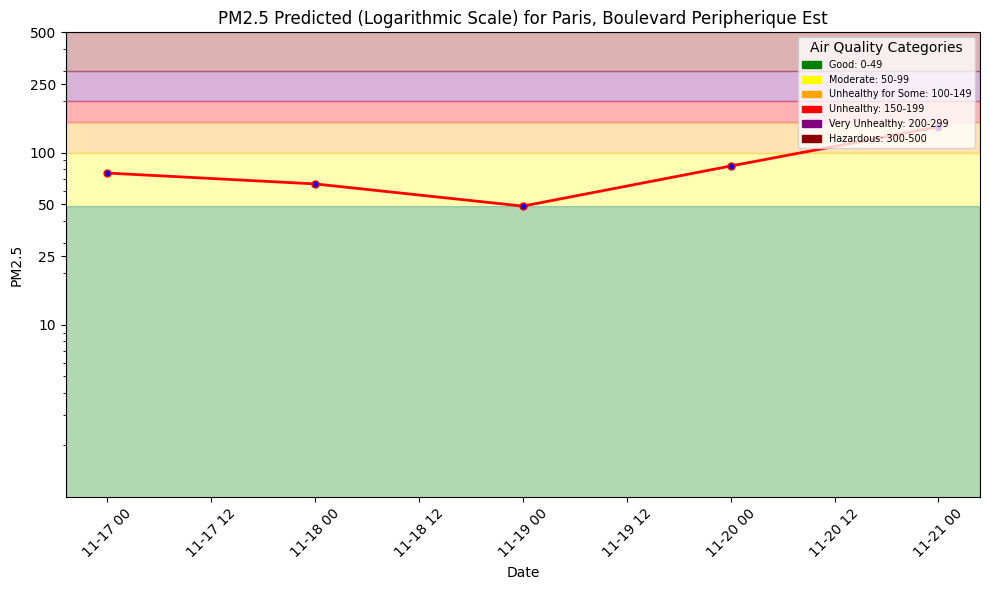

In [27]:

pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, pred_file_path)

plt.show()

In [28]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [29]:
monitor_fg.insert(batch_data, wait=True)

Uploading Dataframe: 100.00% |█████████████████████████████████| Rows 5/5 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1303700/jobs/named/aq_predictions_1_offline_fg_materialization/executions
2025-11-16 00:57:33,191 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED
2025-11-16 00:57:36,370 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-16 00:59:21,275 INFO: Waiting for execution to finish. Current state: FINISHED. Final status: SUCCEEDED
2025-11-16 00:59:21,680 INFO: Waiting for log aggregation to finish.
2025-11-16 00:59:21,682 INFO: Execution finished successfully.


(Job('aq_predictions_1_offline_fg_materialization', 'SPARK'), None)

In [30]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.19s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-21 00:00:00+00:00,5.3,0.0,9.028754,4.573841,Paris,141.292542,Boulevard Peripherique Est,France,1


In [31]:
air_quality_fg = fs.get_feature_group(name='air_quality', version=1)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.07s) 


,date,pm25,country,city,street,url
0,2019-09-01 00:00:00+00:00,29.0,France,Paris,Boulevard Peripherique Est,https://api.waqi.info/feed/@3088/
1,2025-07-07 00:00:00+00:00,24.0,France,Paris,Boulevard Peripherique Est,https://api.waqi.info/feed/@3088/
2,2017-12-02 00:00:00+00:00,101.0,France,Paris,Boulevard Peripherique Est,https://api.waqi.info/feed/@3088/
3,2025-01-17 00:00:00+00:00,86.0,France,Paris,Boulevard Peripherique Est,https://api.waqi.info/feed/@3088/
4,2016-08-12 00:00:00+00:00,39.0,France,Paris,Boulevard Peripherique Est,https://api.waqi.info/feed/@3088/
...,...,...,...,...,...,...
4161,2016-02-19 00:00:00+00:00,62.0,France,Paris,Boulevard Peripherique Est,https://api.waqi.info/feed/@3088/
4162,2019-10-16 00:00:00+00:00,44.0,France,Paris,Boulevard Peripherique Est,https://api.waqi.info/feed/@3088/
4163,2019-10-14 00:00:00+00:00,49.0,France,Paris,Boulevard Peripherique Est,https://api.waqi.info/feed/@3088/
4164,2021-06-30 00:00:00+00:00,40.0,France,Paris,Boulevard Peripherique Est,https://api.waqi.info/feed/@3088/


In [32]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.27s) 


Uploading Dataframe: 100.00% |█████████████████████████████████| Rows 5/5 | Elapsed Time: 00:00 | Remaining Time: 00:00


Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1303700/jobs/named/aq_predictions_1_offline_fg_materialization/executions
2025-11-16 01:00:10,546 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-16 01:00:17,117 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-16 01:01:52,503 INFO: Waiting for execution to finish. Current state: FINISHED. Final status: SUCCEEDED
2025-11-16 01:01:52,910 INFO: Waiting for log aggregation to finish.
2025-11-16 01:01:52,912 INFO: Execution finished successfully.


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,pm25,street,country,days_before_forecast_day
0,2025-11-12 00:00:00+00:00,11.976251,0.0,16.499237,164.581329,Paris,66.885452,48.0,Boulevard Peripherique Est,France,1
1,2025-11-13 00:00:00+00:00,14.822083,0.0,16.502180,176.216385,Paris,62.885426,49.0,Boulevard Peripherique Est,France,1
2,2025-11-14 00:00:00+00:00,15.601249,2.3,13.207634,166.095551,Paris,62.239864,63.0,Boulevard Peripherique Est,France,1
3,2025-11-15 00:00:00+00:00,12.800000,0.3,3.219938,153.435013,Paris,69.340103,44.0,Boulevard Peripherique Est,France,1
4,2025-11-16 00:00:00+00:00,10.700000,0.0,8.473393,12.264770,Paris,67.030495,64.0,Boulevard Peripherique Est,France,1


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

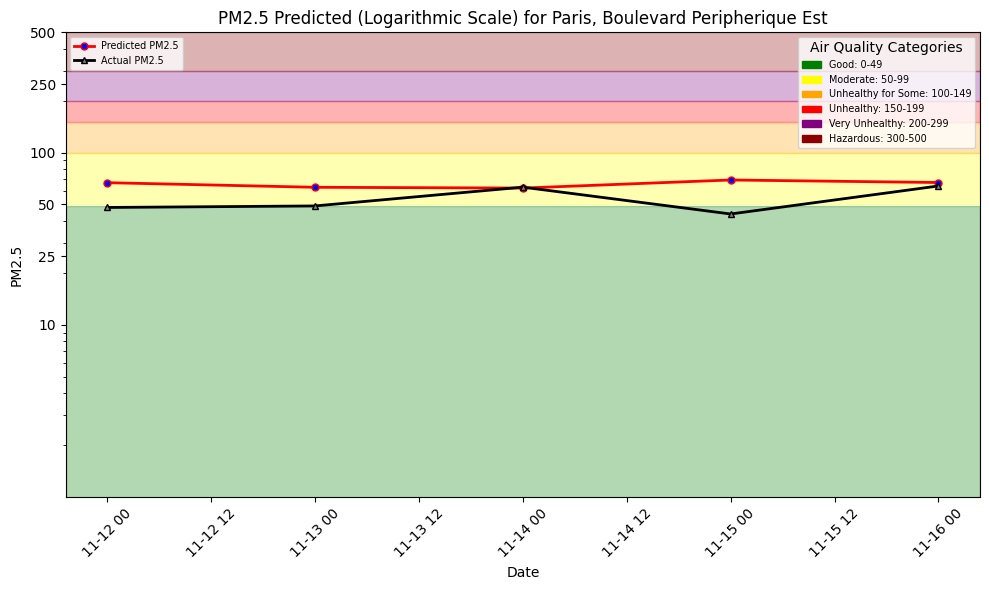

In [33]:
hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)
plt.show()

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [34]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")
dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

Uploading D:\KTH Courses\ID2223 Scalable Machine Learning and Deep Learning\Lab1\mlfs-book-main\mlfs-book-main…

Uploading D:\KTH Courses\ID2223 Scalable Machine Learning and Deep Learning\Lab1\mlfs-book-main\mlfs-book-main…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1303700/settings/fb/path/Resources/airquality


---